In [1]:
# This is similar to the other notebook for creating models, only this is focused on the straight model. As such that notebook contains documentation for the various bits of code and this one does not.

In [24]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
import os
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import joblib

In [2]:
k_mers = ["2","2","4","4","6","6"]
checks = [True,False,True,False,True,False]
colors = ["b","g","r","c","m","y"]
model_probs = []

In [3]:
#os.chdir(os.pardir)

In [5]:
results = []
model_probs = []
for i in range(len(k_mers)):

    #os.chdir(os.pardir)
    Meth = pd.read_csv("processed_data\combined_data\with_background\combined_" + k_mers[i] + "mers_meth_with_background.tsv", sep="\t")
    Unmeth = pd.read_csv("processed_data\combined_data\with_background\combined_" + k_mers[i] + "mers_unmeth_with_background.tsv", sep="\t")
    Meth = Meth.drop(306)
    Unmeth = Unmeth.drop(306)
    Combined = [Meth,Unmeth]
    Healthy_Meth = Meth.loc[Meth["cancer"]=="Healthy"]
    Healthy_Unmeth = Unmeth.loc[Unmeth["cancer"]=="Healthy"]
    Cancer_Meth = Meth.loc[Meth["cancer"]!="Healthy"]
    Cancer_Unmeth = Unmeth.loc[Unmeth["cancer"]=="Healthy"]
    Data0 = Healthy_Meth
    Data1 = Healthy_Unmeth
    Combined = [Healthy_Meth,Healthy_Unmeth,Cancer_Meth,Cancer_Unmeth]
    X = pd.concat(Combined)
    X = X.iloc [:, :-1]
    y = [0] * (Healthy_Meth.shape[0]+Healthy_Unmeth.shape[0]) + [1] * (Cancer_Meth.shape[0] + Cancer_Unmeth.shape[0])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
    if checks == True:
        dim_reduction = PCA()
        X_train = dim_reduction.fit_transform(X_train)
        X_test = dim_reduction.transform(X_test)
        X = dim_reduction.transform(X)
    pipe = make_pipeline(StandardScaler(),LogisticRegression(penalty='l1', solver='liblinear',max_iter=1000))
    param_grid = {
        'logisticregression__C': np.logspace(-3, 1, 100)  
    }
    grid_search = GridSearchCV(pipe, param_grid, cv=10, n_jobs=-1)
    grid_search.fit(X_train, y_train)


    best_model = grid_search.best_estimator_

    train_accuracy = best_model.score(X_train, y_train)
    test_accuracy = best_model.score(X_test, y_test)
    num_selected_variables = np.sum(best_model.named_steps['logisticregression'].coef_ != 0)

    results.append([test_accuracy, grid_search.best_params_["logisticregression__C"], num_selected_variables,[k_mers[i],checks[i]]])


    plt.scatter(grid_search.cv_results_['param_logisticregression__C'], grid_search.cv_results_['mean_test_score'], color = colors[i])
    plt.plot(grid_search.cv_results_['param_logisticregression__C'], grid_search.cv_results_['mean_test_score'], color = colors [i])
    plt.xlabel("C")
    plt.ylabel("Accuracy")
    plt.savefig("Cross_Val " + k_mers[i] + "-mer, PCA = " + str(checks[i]))
    plt.close()
    
   
    dump(best_model,"Straight_Cross_Val_" + k_mers[i] + "_mer__PCA_=_" + str(checks[i]) + ".joblib")
    model_probs.append(best_model.predict_proba(X))

    print("Best model:", best_model)
    print("Best parameter (C):", grid_search.best_params_)
    print("Train accuracy:", train_accuracy)
    print("Test accuracy:", test_accuracy)




Best model: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.18307382802953698, max_iter=1000,
                                    penalty='l1', solver='liblinear'))])
Best parameter (C): {'logisticregression__C': 0.18307382802953698}
Train accuracy: 0.5979166666666667
Test accuracy: 0.5916666666666667
Best model: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.07924828983539177, max_iter=1000,
                                    penalty='l1', solver='liblinear'))])
Best parameter (C): {'logisticregression__C': 0.07924828983539177}
Train accuracy: 0.6166666666666667
Test accuracy: 0.5854166666666667
Best model: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.01788649529057435, max_iter=1000,
                                    penalty='

In [6]:
C = []
N_var = []
Acc = []
k_mer = []
princ = []
for i in range(len(results)):
    C.append(results[i][1])
    Acc.append(results[i][0])
    N_var.append(results[i][2])
    k_mer.append(results[i][3][0])
    princ.append(results[i][3][1])
Extra = pd.DataFrame({'k-mer':k_mer, 'PCA': princ, 'C': C, 'Accuracy': Acc, 'Number of variables': N_var})
Extra

,k-mer,PCA,C,Accuracy,Number of variables
0,2,True,0.183074,0.591667,6
1,2,False,0.079248,0.585417,6
2,4,True,0.017886,0.558333,1
3,4,False,0.049770,0.547917,18
4,6,True,0.025950,0.558333,7
5,6,False,0.025950,0.562500,5


In [19]:
model_probs[0]

array([[0.72173478, 0.27826522],
       [0.62443242, 0.37556758],
       [0.62083617, 0.37916383],
       ...,
       [0.49280917, 0.50719083],
       [0.41450974, 0.58549026],
       [0.51463338, 0.48536662]])

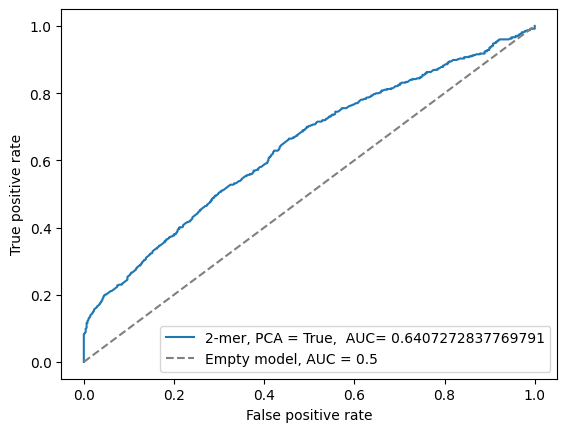

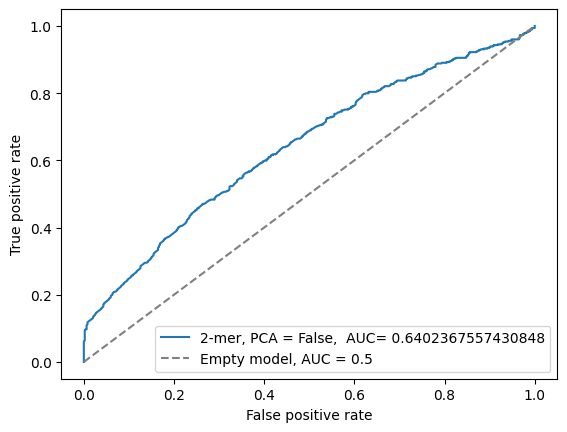

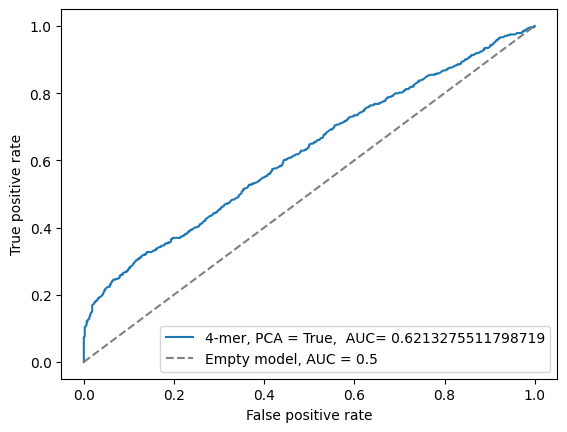

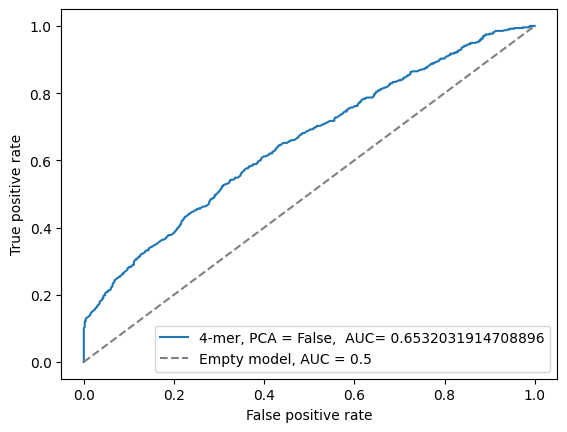

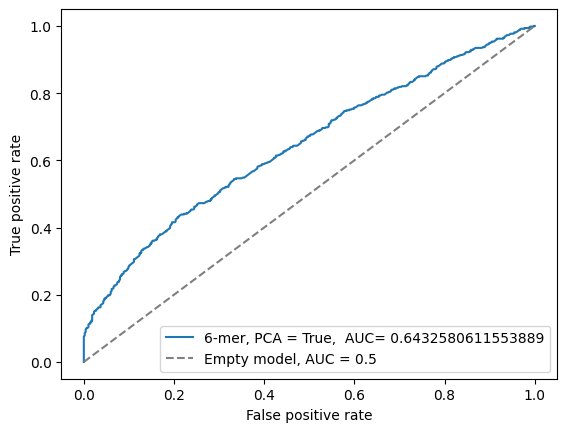

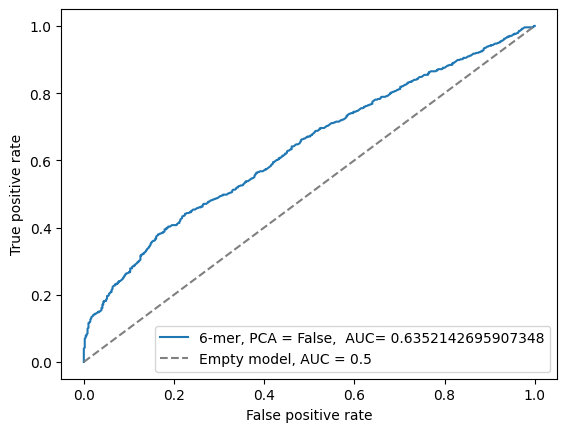

In [23]:
for i in range(len(model_probs)):
    #for j in range(len(model_probs[i])):
            #fig, ax0 = plt.subplots(nrows=1, ncols=1)
            #x = [model_probs[i][0][l],model_probs[i][1][l]]
            #ax0.hist(x, n_bins, density=True, histtype='bar', color=new_colors, label=cancers)
            #ax0.legend(prop={'size': 10})   
            #ax0.set_title(k_mers[i]+"-mer, PCA = " + str(checks[i]) + ", "  + " " + methylation[l])
            y_scores = []
            for j in range(len(model_probs[i])):
                    y_scores.append(model_probs[i][j][1])
            fpr, tpr, _ = metrics.roc_curve(y, y_scores)
            #display = DetCurveDisplay(fpr=fpr, fnr=fnr, estimator_name=k_mers[i]+"-mer, PCA = " + str(checks[i]) + ", "  + " " + methylation[l])
            AUC = metrics.roc_auc_score(y, y_scores)
            #plt.close()
            plt.plot(fpr,tpr, label =  k_mers[i]+"-mer, PCA = " + str(checks[i]) + ", "  + " AUC= " + str(AUC))
            plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label= "Empty model, " +  'AUC = 0.5')
            plt.xlabel("False positive rate")
            plt.ylabel("True positive rate")
            plt.legend(loc = "lower right")
            plt.savefig(fname =k_mers[i]+"-mer, PCA = " + str(checks[i]))
            plt.show()
            plt.close()